## Importing necessary libraries

In [61]:
import math  # For mathematical functions to be used in custom activation and loss function
import numpy as np  # Fast mathematical operations over arrays (like Linear Algebra)
import matplotlib.pyplot as plt  # Visualization library used to plot curves

In [62]:
import math
class Value:
  '''
  We define a custom scalar object Value. This will track both the data and its derivative (gradient)
  as it flows through mathematical operations — effectively building a computational graph for backpropagation.
  '''
  '''
  data: The actual scalar value
  _children: A tuple of Value instances used to produce this node (for graphical purposes).
  _op: A string describing the operation used to create this node (+, *, tanh, etc.).
  _backward: A placeholder function that will later be overwritten with the derivative logic for the appropriate operation.
  label: For visualization purpose.
  grad: Gradient of some Loss function w.r.t. this node. Initialized to 0.
  '''
  def __init__(self, data, _children=(), _op="", label=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self._backward = lambda:None
    self.label=label
    self.grad = 0.0

  # For display purpose to make sure Value when printed displays The `value` instead of memory location.
  def __repr__(self):
    return f"Value(data={self.data})"

  # Overloading add operation and returning value object, also overiding _backward function
  # Supports Value + Value or Value + scalar
  # out becomes the child node with self and other as its parents.
  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data, (self,other),'+')

    # Overiding _backward function for this operation to be used during back propogation to calculate the gradient
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  # right side addition handling
  def __radd__(self,other):
    return self + other

  # Overiding division (Reusing logic defined in __mul__)
  def __truediv__(self,other):
    out = self * other**-1
    return out

  # Overiding _backward function for this operation to be used during back propogation to calculate the gradient
  def __pow__(self,other):
      assert isinstance(other,(int,float))
      out = Value(self.data**other,(self,),f'**{other}')

      def _backward():
          self.grad += (other * self.data**(other-1)) * out.grad
      out._backward = _backward

      return out

  # Overiding subtraction operation
  def __sub__(self,other):
    return self + (-other)
  # Overiding negation operation
  def __neg__(self):
    return self * -1

  # Overiding multiplication operation
  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data, (self,other),'*')

    # Defining gradient logic
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward =  _backward

    return out

  # right hand multiplication
  def __rmul__(self,other):
    return self * other

  # Defining tanh operation to be used as our activation function
  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1 )
    out = Value(t,(self,),'tanh')

    # tanh gradient handling
    def _backward():
      self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out

  # Overiding exponential operation
  def exp(self):
      x = self.data
      out = Value(math.exp(x),(self,),'exp')

      # Defining its gradient logic
      def _backward():
          self.grad += out.data * out.grad
      out._backward = _backward

      return out

  # Traversing the computation graph in reverse topological order to apply backpropagation correctly.
  # A depth-first traversal to sort nodes such that all dependencies of a node are visited before the node itself.
  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)
    # Initialising the root grad as 1 (dL/dL = 1) and calling the _backward fucntion for values defined above to propogate gradients
    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

## Let's create an equation and visualize the `Value` objects in action.

In [63]:
a = Value(2.0,label='a') # Leaf input
b = Value(-3.0,label='b') # Leaf input
c = Value(10.0,label='c') # Leaf input

e = a*b; e.label='e' # e = a * b → -6

d = e + c # d = e + c → 4
d.label = 'd'

f = Value(-2.0,label='f') # Another leaf input

L = d * f; L.label = 'L' # Final output: L = d * f → -8
L  # Value(data=-8.0)

Value(data=-8.0)

Graphviz is open source graph visualization software I have used for visualizing our computation graph.

In [64]:
from graphviz import Digraph # Digraph creates a directed graph, which is how computation flows in forward pass and gradients in backward pass.

def trace(root):
  '''
  Builds the set of all nodes and edges in the computational graph
  starting from the given root node using post-order DFS.
  '''
  nodes,edges = set(),set()
  def build(v):
      if v not in nodes:
          nodes.add(v)
          for child in v._prev:
              edges.add((child,v))
              build(child)
  build(root)
  return nodes,edges

# Creating a left-to-right (LR) directed graph.
def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={"rankdir":"LR"})

    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value create a rectangular node
        dot.node(name=uid,label="{%s | data %.4f | grad %.4f }"%( n.label, n.data, n.grad),shape="record")

        if n._op:
            dot.node(name=uid+n._op,label=n._op)
            dot.edge(uid+n._op,uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

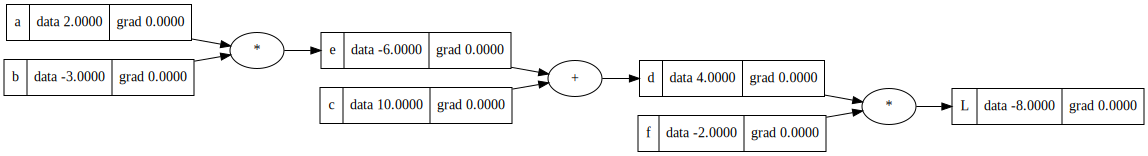

In [65]:
draw_dot(L)

The tanh function being used as our activation function

$$
\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

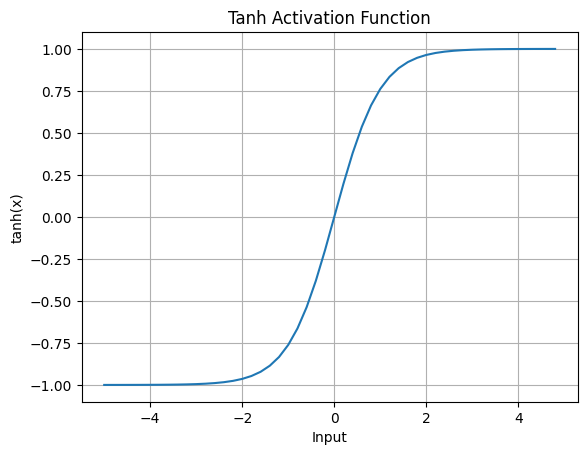

In [66]:
# Plot the tanh activation function used in our neural network.

x = np.arange(-5, 5, 0.2)
y = np.tanh(x)

plt.plot(x, y)
plt.title("Tanh Activation Function")
plt.xlabel("Input")
plt.ylabel("tanh(x)")
plt.grid()
plt.show()

Let's create a neuron to visualize the manual backward pass, to understand how gradients propagate through our computation graph.

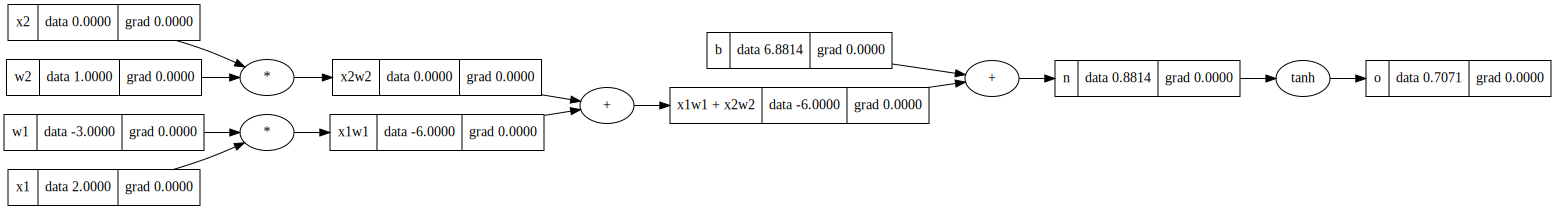

In [136]:
# A single neuron forward pass: computes tanh(x1*w1 + x2*w2 + b)

# Two inputs for our neuron
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# Their weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# Bias for the neuron
b = Value(6.88137358701,label='b')

# Intermediate nodes
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

# Caculating final value
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

# Pass it through our activation function to get final output
o = n.tanh(); o.label = 'o'
draw_dot(o)

In [137]:
o.grad = 1.0
o.backward()

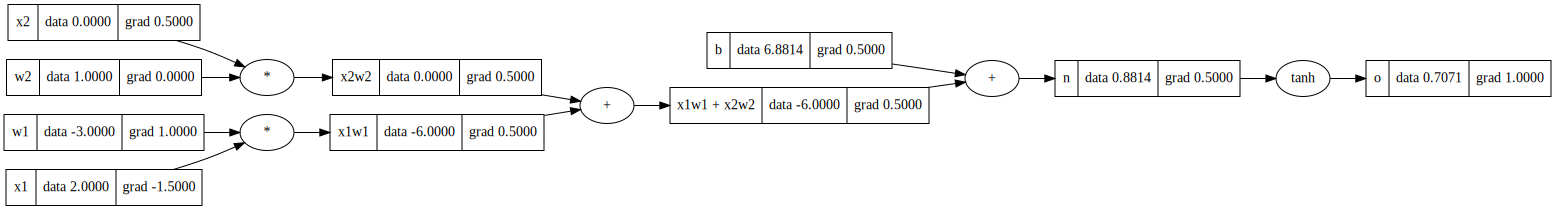

In [138]:
draw_dot(o)

> Reimplementing the same single-neuron computation using PyTorch <br>
This helps us validate that our custom autodiff engine produces correct gradients

In [70]:
import torch

# Define inputs and parameters with requires_grad=True to track gradients (values are same as earlier)
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.88137358701]).double(); b.requires_grad = True

# Forward pass: weighted sum + tanh activation
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# Backpropagation: compute gradients
print(o.data.item())
o.backward()

# Gradient values after back propogation
print('x2',x2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())

0.7071066904050358
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


> We can see the value of gradients in our pytorch code matches the ones calculated using our custom objects. Hence, our auto diff logic work perfectly.

Now we'll move on to designing our neural network with the help of the `Value` class deifned earlier. First we'll create our `Neuron` class.

In [92]:
import random
# A single artificial neuron: computes a weighted sum of inputs followed by a non-linear activation (tanh)
class Neuron:
  def __init__(self,nin):
      # Initialize weights and bias with random values
      self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
      self.b = Value(random.uniform(-1,1))

  def __call__(self,x):
      # Compute activation: w · x + b
      act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
      # Apply non-linearity (tanh)
      out = act.tanh()
      return out

  def parameters(self):
      # Return all parameters (weights and bias)
      return self.w + [self.b]

In [93]:
# A fully connected layer of neurons
class Layer:
  def __init__(self,nin,nout):
      # Create a layer with nout neurons, each expecting nin inputs
      self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
      # Forward pass: pass input x through each neuron
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs) == 1 else outs

  def parameters(self):
      # Aggregate parameters from all neurons in the layer
      return [p for neuron in self.neurons for p in neuron.parameters()]

In [115]:
# A multi-layer perceptron (MLP): a sequence of fully connected layers
class MLP:
  def __init__(self,nin,nouts):
      # nin: number of input features
      # nouts: list specifying number of neurons in each layer
      sz = [nin] + nouts
      self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
      # Forward pass: feed input through each layer
      for layer in self.layers:
          x = layer(x)
      return x

  def zero_grad(self):
      # Set all parameters gradients to 0
      for p in self.parameters():
          p.grad = 0.0

  def parameters(self):
      # Aggregate all trainable parameters in the network
      return [p for layer in self.layers for p in layer.parameters()]

Example usage of the MLP:
- Input layer: size 3
- First hidden layer: 4 neurons
- Second hidden layer: 4 neurons
- Output layer: 1 neuron
<br>
Meaning our neural network has total of 9 neurons with a totl of 41 parameters.

In [141]:
x = [2.0, 3.0, -4.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.682159780549799)

In [142]:
len(n.parameters())

41

### Visualize the computational graph of the output Value

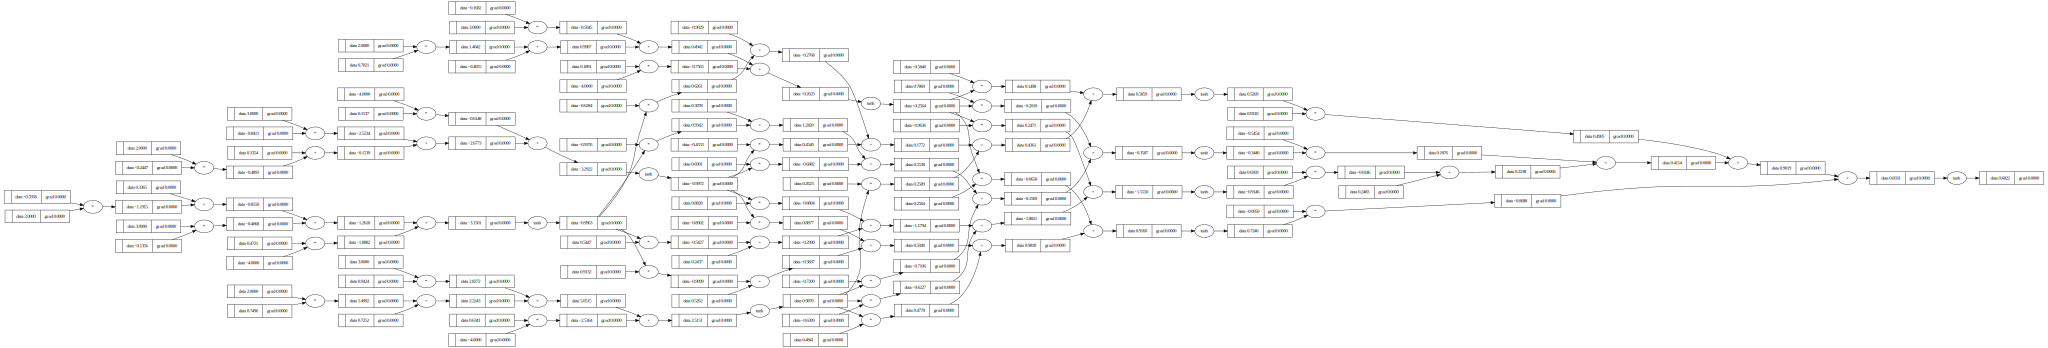

In [146]:
figure = draw_dot(n(x))
figure

These are your 4 training samples. Each x has 3 features, and each y is a scalar regression target.

In [117]:
# Sample training dataset
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
    ]

ys = [1.0,-1.0,-1.0,1.0] # Target outputs

ypred = [n(x) for x in xs]
ypred

[Value(data=0.9404891309878213),
 Value(data=-0.9608903842045877),
 Value(data=-0.915337713753532),
 Value(data=0.9082885474165143)]

In [103]:
# Compute total loss (MSE)
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=3.449169227314017)

In [104]:
loss.backward() # Backward pass: perform reverse-mode autodiff

In [105]:
# Gradient descent: update each parameter using its gradient
for p in n.parameters():
  p.data += -0.01 * p.grad

In [106]:
# Calculate y again with updated gradients
ypred = [n(x) for x in xs]
ypred

[Value(data=0.46125239789623573),
 Value(data=-0.2837358023570222),
 Value(data=0.1849881003688081),
 Value(data=0.2758543076028171)]

We can see improvement in prediction of y but this method of manually running backward and updating gradients is tiresome let's create a function to run it for n `epochs`.

In [118]:
# Using the same pair of inputs and outputs
# Sample training dataset
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
    ]

ys = [1.0,-1.0,-1.0,1.0] # Target outputs

In [131]:
x = [2.0, 3.0, -4.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.6621774911812679)

In [132]:
losses = []  # store loss values for each epoch
for k in range(20): # Can modify `epochs` accordingly

    # Forward pass: predict outputs for each input
    ypred = [n(x) for x in xs]
    # Compute loss using Mean Squared Error (MSE)
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
    losses.append(loss.data)

    # Backward pass: clear existing gradients and compute new ones
    n.zero_grad()
    loss.backward()

    # Gradient descent: update parameters using learning rate 0.01 (can change this to match your needs)
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print("Epoch -> ", k+1, "MSE -> ", loss.data)

Epoch ->  1 MSE ->  2.408840597092688
Epoch ->  2 MSE ->  2.1633118599525516
Epoch ->  3 MSE ->  1.958666313188845
Epoch ->  4 MSE ->  1.7788494435640365
Epoch ->  5 MSE ->  1.616071599552722
Epoch ->  6 MSE ->  1.4669492481793511
Epoch ->  7 MSE ->  1.330180974165867
Epoch ->  8 MSE ->  1.2052915233882835
Epoch ->  9 MSE ->  1.091996466868152
Epoch ->  10 MSE ->  0.9899184679931416
Epoch ->  11 MSE ->  0.8984993650070585
Epoch ->  12 MSE ->  0.8170129871662816
Epoch ->  13 MSE ->  0.7446197874497458
Epoch ->  14 MSE ->  0.680429159175607
Epoch ->  15 MSE ->  0.6235526055903818
Epoch ->  16 MSE ->  0.5731419715650207
Epoch ->  17 MSE ->  0.5284129800951813
Epoch ->  18 MSE ->  0.48865689836892456
Epoch ->  19 MSE ->  0.4532437319625744
Epoch ->  20 MSE ->  0.42161996530366186


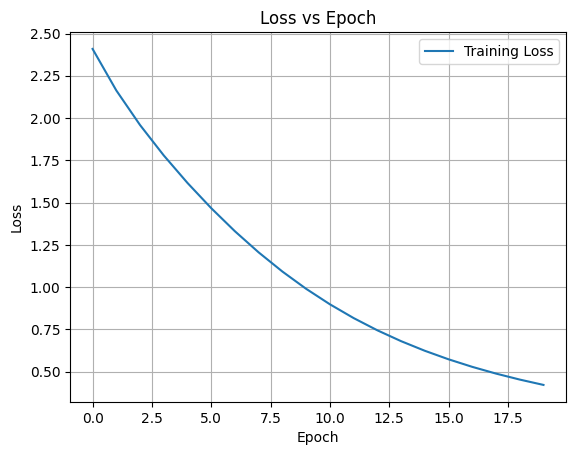

In [153]:
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.grid(True)
plt.legend()
# plt.savefig("loss_curve.png") # Code for saving the loss graph
plt.show()

# Final model predictions after training

In [134]:
ypred
# ys = [1.0,-1.0,-1.0,1.0] -> Target outputs

[Value(data=0.7963012977709912),
 Value(data=-0.8371035116995176),
 Value(data=-0.5337044593666868),
 Value(data=0.6310013456681225)]

In [148]:
# figure.render('mlp_graph', format='svg') # Code for saving the computational graph

'mlp_graph.svg'